In [1]:
import os
import sys
import json
import random
sys.path.append('..')

import lre.models as models
from lre.data import Relation, RelationSample, Sequence
import lre.functional as functional
import lre.metrics as metrics

from transformers import GPTJForCausalLM, AutoTokenizer
import numpy as np
import torch

device = 'cuda:0'
weights = []
biases = []
subjects = []
model = GPTJForCausalLM.from_pretrained("EleutherAI/gpt-j-6B", revision="float16", torch_dtype=torch.float16, low_cpu_mem_usage=True)
model.to(device)
tokenizer = AutoTokenizer.from_pretrained("EleutherAI/gpt-j-6B")
tokenizer.pad_token = tokenizer.eos_token
mt = models.ModelAndTokenizer(model,tokenizer)

/home/exia/miniconda3/envs/my-lre/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
mt.model.transformer.h[5].attn

GPTJAttention(
  (attn_dropout): Dropout(p=0.0, inplace=False)
  (resid_dropout): Dropout(p=0.0, inplace=False)
  (k_proj): Linear(in_features=4096, out_features=4096, bias=False)
  (v_proj): Linear(in_features=4096, out_features=4096, bias=False)
  (q_proj): Linear(in_features=4096, out_features=4096, bias=False)
  (out_proj): Linear(in_features=4096, out_features=4096, bias=False)
)

In [2]:
#Given: tensor, list of tensors, or list of list of tensors
#Returns: the sequence as float32 numpy
def ttnp(tensor):
    if isinstance(tensor, torch.Tensor):
        tensor = tensor.detach().cpu().numpy().astype(np.float32)
        #tensor /= np.linalg.norm(tensor)
        return tensor
        
    elif isinstance(tensor[0], torch.Tensor):
        l = [x.detach().cpu().numpy()[0].astype(np.float32) for x in tensor]
        #l = [x / np.linalg.norm(x) for x in l]
        return l
        
    elif isinstance(tensor[0][0], torch.Tensor):
        return [[x.detach().cpu().numpy()[0].astype(np.float32) for x in l] for l in tensor]
    else:
        return tensor


In [3]:
def get_range(tensors, axis_tensor):
    np_tensors = ttnp(tensors)
    projs = []
    for tensor in np_tensors:
        proj = np.dot(tensor, axis_tensor)
        projs.append(proj)
    proj_range = np.max(projs) - np.min(projs)
    return proj_range

#Given a list of tensors and an axis tensor
#Computes the mean variance w.r.t. the axis tensor
def get_variance(tensors, axis_tensor):
    np_tensors = ttnp(tensors)
    variances = []
    for tensor in np_tensors:
        variance = np.mean((tensor - axis_tensor)**2)
        variances.append(variance)
    variance = np.mean(variances)
    return variance
    
def get_avg_dist(tensors):
    dists = []
    np_tensors = ttnp(tensors)
    for tensor in np_tensors:
        for tensor2 in np_tensors:
            tensor = tensor.astype(np.float32)
            tensor2 = tensor2.astype(np.float32)
            dists.append(np.linalg.norm(tensor - tensor2))
        return np.mean(dists, axis=0)

In [4]:
mt.tokenizer('colonization')
tokens = [mt.tokenizer.decode(x) for x in mt.tokenizer('colonization').input_ids]
tokens

['col', 'on', 'ization']

In [5]:
mt.tokenizer('colonization')
tokens = [mt.tokenizer.decode(x) for x in mt.tokenizer('colonization').input_ids]

SyntaxError: incomplete input (4180050767.py, line 2)

In [6]:
mt.tokenizer('reinforce')

{'input_ids': [260, 259, 3174], 'attention_mask': [1, 1, 1]}

In [12]:
from importlib import reload
import llra.viz as viz
import llra.build as build
import lre.functional as functional

reload(build)
reload(functional)
reload(viz)
build.determine_device(mt)
build.determine_params(mt)
start, end = 8, 27
APPROX_FOLDER = f'{start}_{end}_approx'
WEIGHT_NAME = f's_o_weight_{start}_{end}'
BIAS_NAME = f's_o_bias_{start}_{end}'
DEFAULT_N_ICL = 8 
N_TRIALS = 8
VIEW_SAMPLES = 50

5,name - nationality,11,14
ws_minus_s_hs.shape=(4096,)
bias.shape=(4096,)
cosine similarities pre_orthog=0.064 post_orthog=-0.000
proj_matrix.shape=(2, 4096)
['wagner', 'locke', 'dostoyevsky', 'michelangelo', 'caesar', 'fermi', 'truman', 'jolie', 'balzac', 'pascal', 'raphael', 'descartes', 'mozart', 'kepler', 'machiavelli', 'lincoln', 'lavoisier', 'lenin', 'lennon', 'rousseau', 'marx', 'gorbachev', 'mencius', 'galilei', 'newton', 'dickens', 'copernicus', 'aristotle', 'strauss', 'darwin', 'beethoven', 'hume', 'tchaikovsky', 'hitler', 'confucius', 'hegel', 'kant', 'einstein', 'plato', 'edison', 'napoleon', 'hawking', 'leibniz']


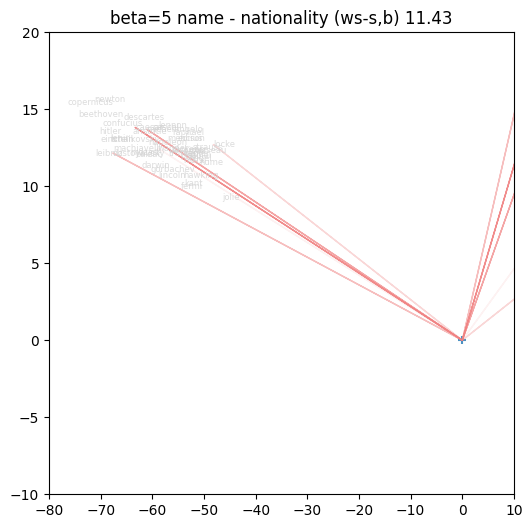

5,animal - youth,23,10
ws_minus_s_hs.shape=(4096,)
bias.shape=(4096,)
cosine similarities pre_orthog=-0.147 post_orthog=-0.000
proj_matrix.shape=(2, 4096)
['duck', 'skunk', 'rabbit', 'camel', 'panda', 'herring', 'salmon', 'beaver', 'cricket', 'dog', 'woodchuck', 'seal', 'badger', 'buffalo', 'fox', 'beetle', 'fish', 'raccoon', 'horse', 'cattle', 'goldfish', 'ox', 'chimpanzee', 'pig', 'shark', 'butterfly', 'fly', 'insect', 'tiger', 'whale', 'weasel', 'muskrat', 'elephant', 'ape', 'snake', 'lion', 'goat', 'mink', 'wolf', 'bee', 'sheep', 'cat', 'trout', 'bear', 'ferret']


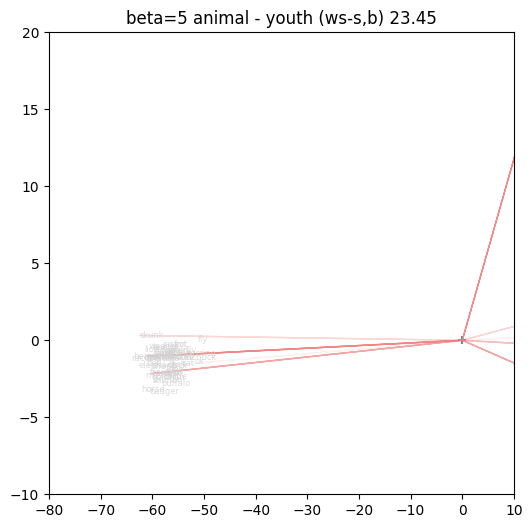

5,verb_Ving - 3pSg,46,9
ws_minus_s_hs.shape=(4096,)
bias.shape=(4096,)
cosine similarities pre_orthog=-0.162 post_orthog=0.000
proj_matrix.shape=(2, 4096)
['considering', 'understanding', 'providing', 'requiring', 'adding', 'remaining', 'enabling', 'performing', 'representing', 'becoming', 'thanking', 'involving', 'relating', 'applying', 'promoting', 'creating', 'reducing', 'asking', 'hearing', 'advertising', 'losing', 'occurring', 'operating', 'developing', 'learning', 'explaining', 'happening', 'appearing', 'improving', 'managing', 'receiving', 'spending', 'discovering', 'describing', 'teaching', 'seeming', 'continuing', 'existing', 'believing', 'suggesting', 'containing', 'depending', 'following', 'sitting', 'referring', 'publishing', 'telling', 'including', 'allowing', 'consisting']


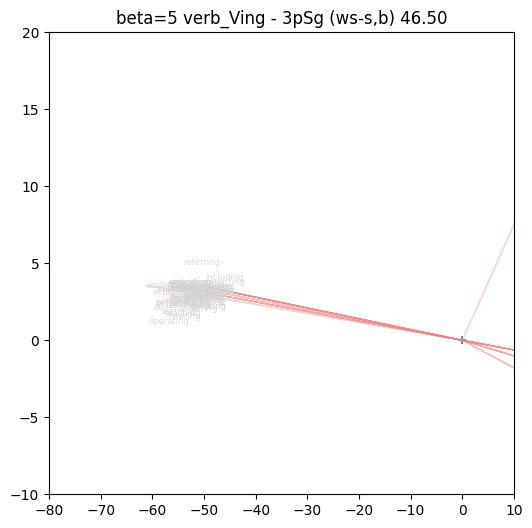

5,noun+less_reg,47,46
ws_minus_s_hs.shape=(4096,)
bias.shape=(4096,)
cosine similarities pre_orthog=-0.045 post_orthog=0.000
proj_matrix.shape=(2, 4096)
['soul', 'emotion', 'luck', 'odor', 'remorse', 'god', 'ruth', 'leg', 'gender', 'death', 'friction', 'meat', 'guilt', 'law', 'penny', 'defence', 'art', 'home', 'collar', 'sleeve', 'effort', 'error', 'breath', 'talent', 'guile', 'money', 'goal', 'wit', 'hair', 'spine', 'heart', 'arm', 'heir', 'faith', 'speech', 'bone', 'life', 'carbon', 'tact', 'tooth', 'path', 'passion', 'child', 'ego', 'window', 'friend', 'expression', 'sensor', 'thought']


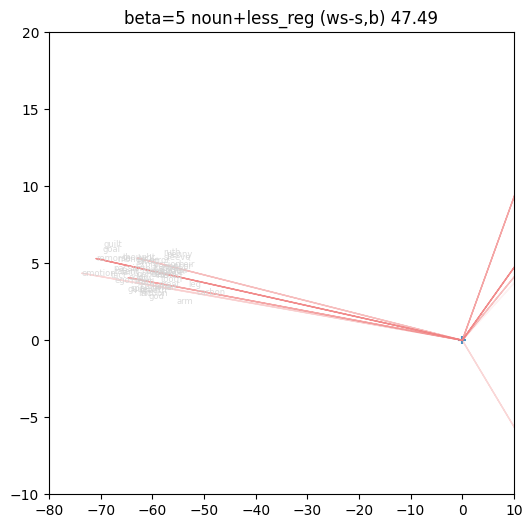

5,verb+able_reg,38,27
ws_minus_s_hs.shape=(4096,)
bias.shape=(4096,)
cosine similarities pre_orthog=-0.116 post_orthog=0.000
proj_matrix.shape=(2, 4096)
['represent', 'execute', 'predict', 'edit', 'replace', 'recommend', 'discover', 'avoid', 'achieve', 'consider', 'improve', 'advise', 'define', 'maintain', 'adapt', 'protect', 'publish', 'imagine', 'adore', 'rely', 'expand', 'accept', 'recognize', 'foresee', 'prefer', 'vary', 'renew', 'admire', 'extend', 'perform', 'survive', 'learn', 'believe', 'adjust', 'inflate', 'understand', 'expect', 'contain', 'deliver', 'sustain', 'observe', 'write', 'afford', 'identify', 'dispose', 'prevent', 'manage', 'download', 'explain', 'enjoy']


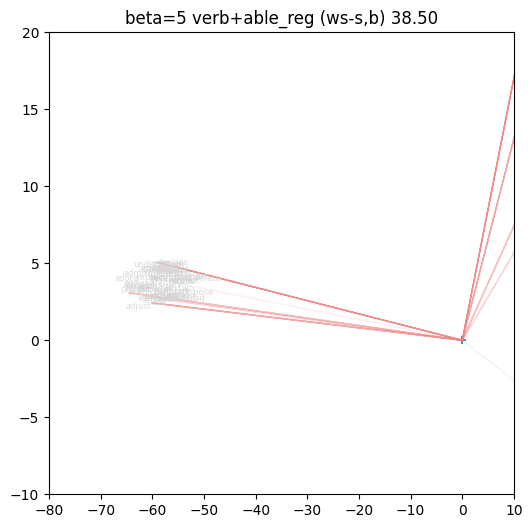

5,UK_city - county,10,7
ws_minus_s_hs.shape=(4096,)
bias.shape=(4096,)
cosine similarities pre_orthog=-0.010 post_orthog=-0.000
proj_matrix.shape=(2, 4096)
['cambridge', 'plymouth', 'derby', 'aberdeen', 'brighton', 'norwich', 'ely', 'inverness', 'lincoln', 'exeter', 'leicester', 'wolverhampton', 'birmingham', 'gloucester', 'hereford', 'newcastle', 'coventry', 'worcester', 'salisbury', 'salford', 'nottingham', 'oxford']


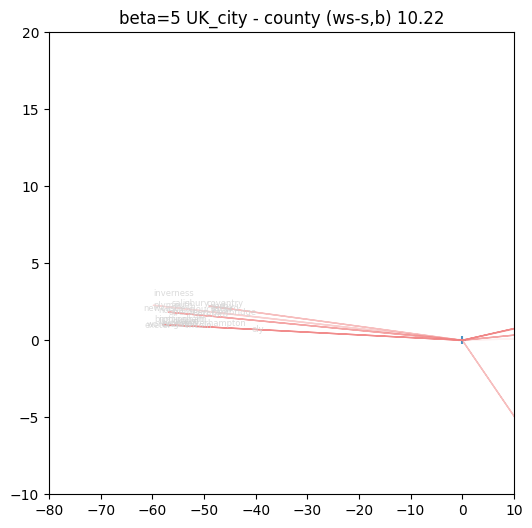

5,antonyms - binary,37,36
ws_minus_s_hs.shape=(4096,)
bias.shape=(4096,)
cosine similarities pre_orthog=-0.254 post_orthog=-0.000
proj_matrix.shape=(2, 4096)
['off', 'proceed', 'inhale', 'down', 'decrement', 'submerge', 'up', 'southeast', 'downslope', 'backward', 'under', 'inside', 'interior', 'descend', 'toward', 'inbound', 'over', 'exit', 'in', 'true', 'fall', 'below', 'rise', 'dynamic', 'before', 'previously', 'after', 'dead', 'west', 'mortal', 'anterior', 'occupied', 'first', 'top', 'drop', 'climb', 'forward', 'employ', 'forget', 'beginning', 'out', 'uphill', 'input', 'internal', 'ahead', 'south', 'front']


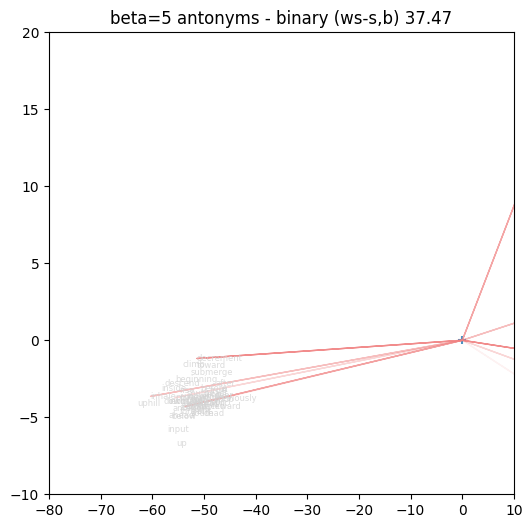

5,verb_inf - 3pSg,48,38
ws_minus_s_hs.shape=(4096,)
bias.shape=(4096,)
cosine similarities pre_orthog=-0.128 post_orthog=-0.000
proj_matrix.shape=(2, 4096)
['include', 'become', 'understand', 'describe', 'involve', 'identify', 'consider', 'create', 'prevent', 'avoid', 'contain', 'learn', 'promote', 'send', 'ensure', 'receive', 'appear', 'seem', 'explain', 'happen', 'occur', 'refer', 'add', 'improve', 'apply', 'consist', 'require', 'tell', 'agree', 'enable', 'develop', 'follow', 'maintain', 'remain', 'reduce', 'remember', 'represent', 'believe', 'exist', 'hear', 'enjoy', 'protect', 'continue', 'accept', 'achieve', 'suggest', 'ask', 'allow', 'provide', 'operate']


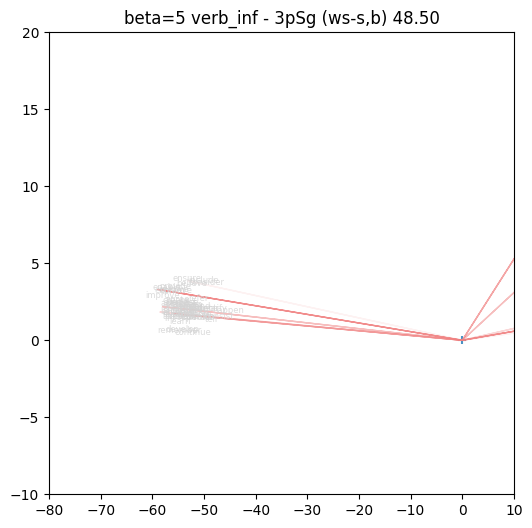

5,re+verb_reg,50,0
ws_minus_s_hs.shape=(4096,)
bias.shape=(4096,)
cosine similarities pre_orthog=-0.257 post_orthog=0.000
proj_matrix.shape=(2, 4096)
['send', 'solve', 'grow', 'examine', 'evaluate', 'decorate', 'configure', 'consider', 'assess', 'calculate', 'acquire', 'apply', 'appoint', 'learn', 'discover', 'submit', 'upload', 'investigate', 'assign', 'publish', 'negotiate', 'interpret', 'commend', 'distribute', 'integrate', 'assure', 'develop', 'cognize', 'establish', 'define', 'marry', 'install', 'organize', 'locate', 'deem', 'appear', 'connect', 'write', 'tell', 'unite', 'create', 'introduce', 'engage', 'generate', 'arrange', 'emerge', 'confirm', 'invest', 'adjust', 'occur']


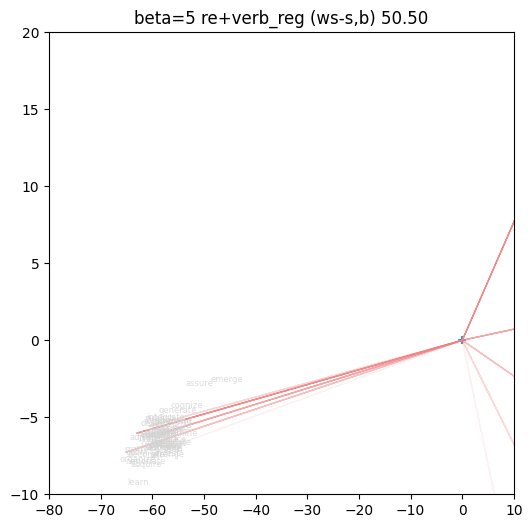

5,verb_inf - Ved,41,40
ws_minus_s_hs.shape=(4096,)
bias.shape=(4096,)
cosine similarities pre_orthog=-0.231 post_orthog=0.000
proj_matrix.shape=(2, 4096)
['ask', 'manage', 'spend', 'refer', 'expect', 'hear', 'receive', 'develop', 'consider', 'publish', 'believe', 'agree', 'decide', 'identify', 'provide', 'seem', 'enjoy', 'relate', 'tell', 'involve', 'send', 'accept', 'add', 'describe', 'apply', 'continue', 'introduce', 'replace', 'create', 'perform', 'establish', 'require', 'follow', 'include', 'remain', 'improve', 'lose', 'locate', 'understand', 'become', 'ensure', 'marry', 'unite', 'reduce', 'allow', 'appear', 'attend', 'discover', 'announce', 'achieve']


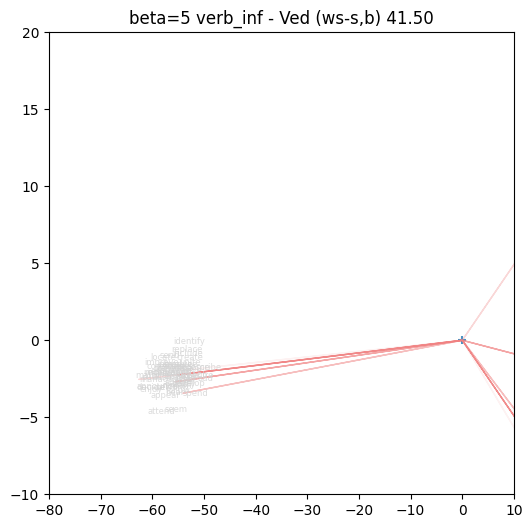

5,country - language,20,7
ws_minus_s_hs.shape=(4096,)
bias.shape=(4096,)
cosine similarities pre_orthog=-0.028 post_orthog=-0.000
proj_matrix.shape=(2, 4096)
['ireland', 'cambodia', 'fiji', 'guyana', 'morocco', 'guam', 'cuba', 'kosovo', 'guatemala', 'switzerland', 'denmark', 'mozambique', 'barbados', 'colombia', 'brazil', 'usa', 'palestine', 'syria', 'chile', 'jamaica', 'moldova', 'philippines', 'kuwait', 'bangladesh', 'australia', 'iran', 'andorra', 'venezuela', 'canada', 'norway', 'israel', 'egypt', 'taiwan', 'jordan', 'ecuador', 'haiti', 'argentina', 'mexico', 'guadeloupe', 'peru', 'ethiopia', 'bolivia', 'bahamas', 'cyprus', 'nicaragua', 'iraq', 'belize']


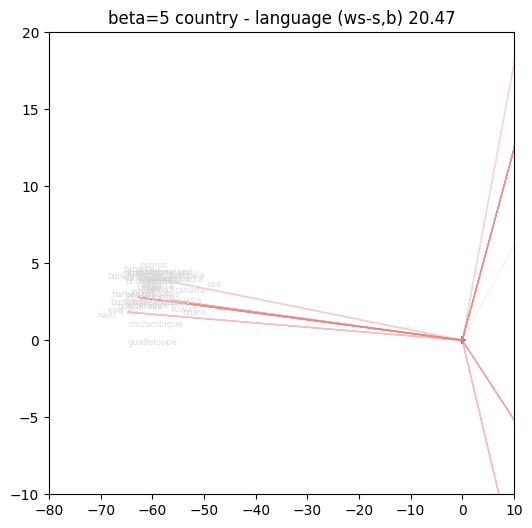

5,meronyms - part,19,16
ws_minus_s_hs.shape=(4096,)
bias.shape=(4096,)
cosine similarities pre_orthog=-0.255 post_orthog=-0.000
proj_matrix.shape=(2, 4096)
['piano', 'flower', 'car', 'table', 'bus', 'byte', 'jewellery', 'jail', 'guitar', 'torso', 'womb', 'sword', 'telephone', 'movie', 'chair', 'teapot', 'comb', 'shirt', 'dollar', 'cat', 'seafront', 'academia', 'orthography', 'bird', 'tonne', 'poem', 'litre', 'castle', 'deer', 'gun', 'harbor', 'apartment', 'sonata', 'window', 'pub', 'pie', 'day', 'dress', 'staircase', 'brush', 'tripod', 'door', 'radio', 'typewriter']


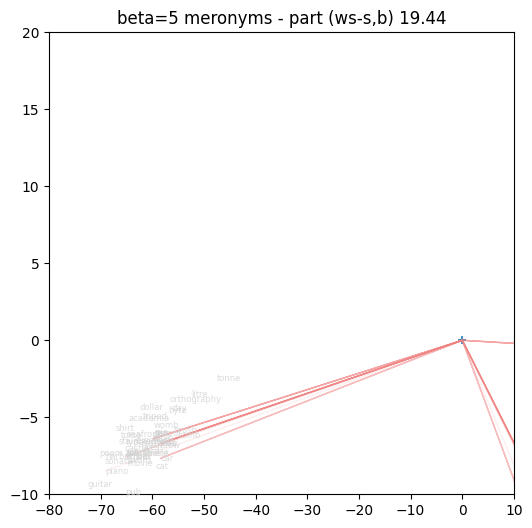

5,verb_Ving - Ved,48,11
ws_minus_s_hs.shape=(4096,)
bias.shape=(4096,)
cosine similarities pre_orthog=-0.167 post_orthog=-0.000
proj_matrix.shape=(2, 4096)
['providing', 'improving', 'operating', 'expecting', 'failing', 'proposing', 'appearing', 'continuing', 'reducing', 'attending', 'announcing', 'spending', 'allowing', 'containing', 'teaching', 'asking', 'uniting', 'describing', 'becoming', 'locating', 'telling', 'marrying', 'suffering', 'creating', 'appointing', 'existing', 'agreeing', 'understanding', 'receiving', 'sending', 'involving', 'requiring', 'performing', 'including', 'developing', 'representing', 'establishing', 'publishing', 'applying', 'losing', 'following', 'introducing', 'deciding', 'hearing', 'adding', 'relating', 'remaining', 'considering', 'replacing', 'managing']


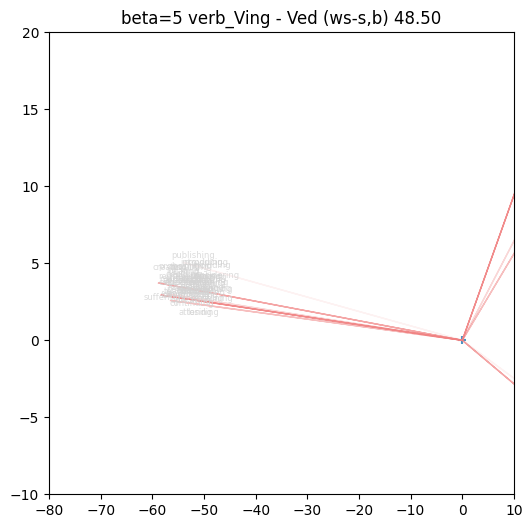

5,animal - shelter,24,2
ws_minus_s_hs.shape=(4096,)
bias.shape=(4096,)
cosine similarities pre_orthog=-0.141 post_orthog=0.000
proj_matrix.shape=(2, 4096)
['beaver', 'goldfish', 'fly', 'fish', 'cockroach', 'wasp', 'mouse', 'hamster', 'chimpanzee', 'fox', 'cattle', 'cricket', 'mallard', 'whale', 'spider', 'bat', 'dog', 'wolf', 'seal', 'trout', 'mole', 'snake', 'ant', 'lion', 'bear', 'raven', 'herring', 'scorpion', 'duck', 'rabbit', 'pig', 'tiger', 'hedgehog', 'monkey', 'hornet', 'crocodile', 'bee', 'locust', 'hippopotamus', 'crow', 'insect', 'dolphin', 'rat', 'horse']


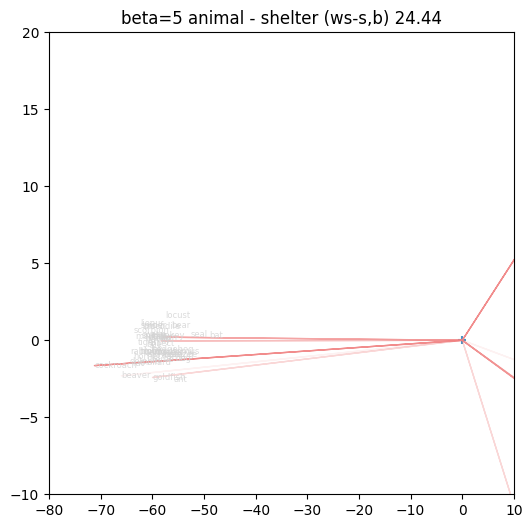

5,hypernyms - misc,24,11
ws_minus_s_hs.shape=(4096,)
bias.shape=(4096,)
cosine similarities pre_orthog=-0.250 post_orthog=0.000
proj_matrix.shape=(2, 4096)
['bracelet', 'grapefruit', 'notepad', 'perfume', 'shelf', 'necklace', 'peach', 'toothbrush', 'tub', 'stapler', 'mascara', 'pastry', 'cake', 'diary', 'skirt', 'sweater', 'tv', 'cup', 'armchair', 'dress', 'dishwasher', 'pie', 'juicer', 'sunscreen', 'desk', 'hamburger', 'sofa', 'lotion', 'croissant', 'denim', 'blender', 'lemon', 'shirt', 'toaster', 'hairpin', 'fridge', 'jacket', 'vase', 'jeans', 'postcard', 'brooch', 'plum', 'photo', 'gasoline']


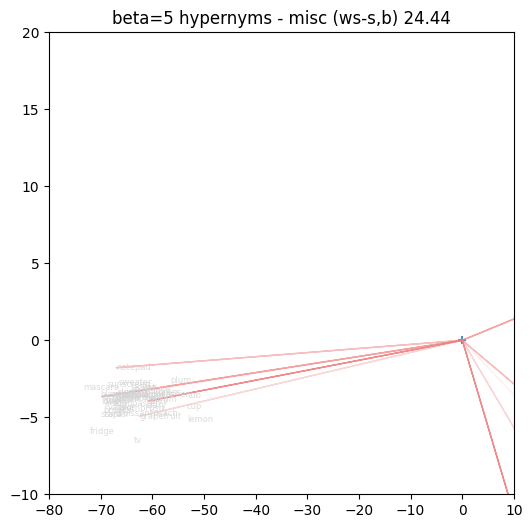

5,meronyms - substance,30,18
ws_minus_s_hs.shape=(4096,)
bias.shape=(4096,)
cosine similarities pre_orthog=-0.220 post_orthog=0.000
proj_matrix.shape=(2, 4096)
['chocolate', 'sea', 'pastry', 'table', 'steel', 'mirror', 'spoon', 'body', 'concrete', 'snow', 'atmosphere', 'lawn', 'lens', 'plastic', 'box', 'diamond', 'pill', 'roof', 'wine', 'boots', 'ocean', 'ice', 'bowl', 'beard', 'clothing', 'penny', 'bronze', 'wall', 'wig', 'bread', 'icicle', 'omelette', 'house', 'cocktail', 'money', 'cloud', 'wire', 'candy', 'beach', 'bag', 'glacier', 'water', 'yogurt', 'flag', 'desk', 'bottle', 'doorknob', 'jeans', 'jam']


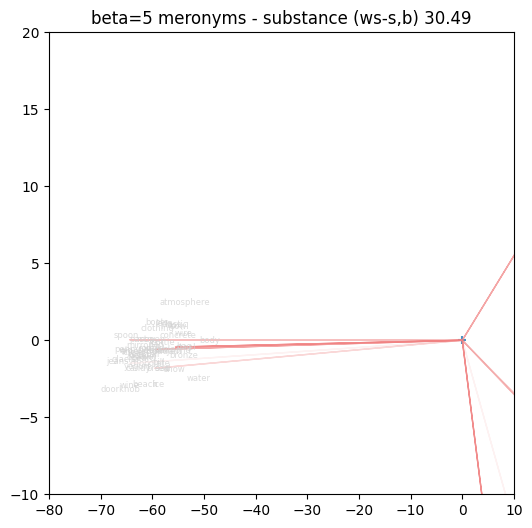

5,noun - plural_irreg,46,44
ws_minus_s_hs.shape=(4096,)
bias.shape=(4096,)
cosine similarities pre_orthog=-0.229 post_orthog=0.000
proj_matrix.shape=(2, 4096)
['success', 'community', 'history', 'industry', 'energy', 'library', 'country', 'property', 'army', 'authority', 'life', 'academy', 'majority', 'category', 'theory', 'variety', 'safety', 'ability', 'story', 'responsibility', 'university', 'agency', 'policy', 'county', 'duty', 'species', 'woman', 'child', 'entry', 'family', 'basis', 'opportunity', 'loss', 'economy', 'series', 'century', 'security', 'memory', 'business', 'secretary', 'formula', 'strategy', 'activity', 'society', 'technology', 'datum', 'facility', 'analysis', 'city', 'wife']


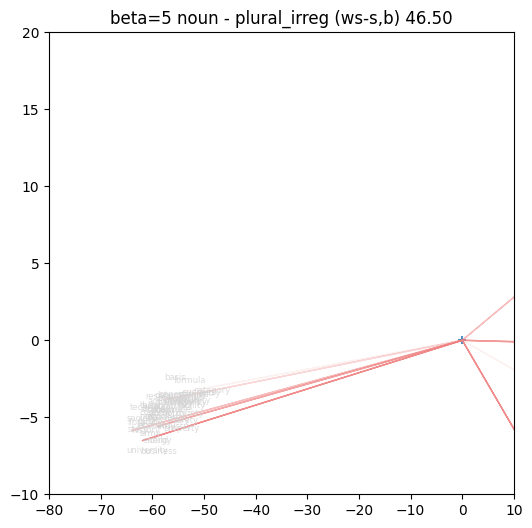

5,un+adj_reg,39,16
ws_minus_s_hs.shape=(4096,)
bias.shape=(4096,)
cosine similarities pre_orthog=-0.221 post_orthog=0.000
proj_matrix.shape=(2, 4096)
['related', 'noticed', 'predictable', 'popular', 'wanted', 'believable', 'expected', 'used', 'interrupted', 'successful', 'usual', 'specified', 'intended', 'reliable', 'veiled', 'suitable', 'realistic', 'conditional', 'lawful', 'certain', 'affected', 'comfortable', 'lucky', 'paid', 'fortunate', 'authorized', 'aware', 'satisfactory', 'conscious', 'identified', 'pleasant', 'finished', 'available', 'happy', 'restricted', 'able', 'biased', 'changed', 'forgettable', 'reasonable', 'controlled', 'avoidable', 'healthy', 'published', 'employed', 'known', 'sustainable', 'resolved', 'desirable', 'acceptable']


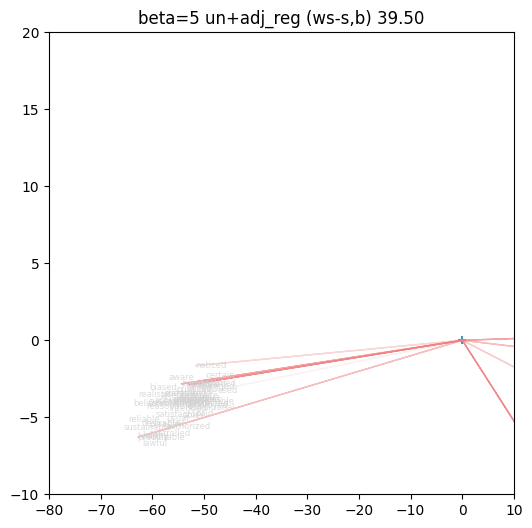

5,verb+ment_irreg,47,48
ws_minus_s_hs.shape=(4096,)
bias.shape=(4096,)
cosine similarities pre_orthog=-0.039 post_orthog=0.000
proj_matrix.shape=(2, 4096)
['impair', 'resent', 'equip', 'involve', 'invest', 'require', 'acknowledge', 'infringe', 'harass', 'reimburse', 'commit', 'achieve', 'displace', 'agree', 'disappoint', 'announce', 'enroll', 'amend', 'punish', 'encourage', 'assess', 'develop', 'disagree', 'endorse', 'accomplish', 'enjoy', 'appoint', 'assign', 'align', 'embarrass', 'enforce', 'enhance', 'entertain', 'establish', 'redevelop', 'enlighten', 'engage', 'detach', 'entitle', 'reinforce', 'fulfill', 'replace', 'arrange', 'manage', 'excite', 'adjust', 'amuse', 'improve', 'fulfil', 'advertise']


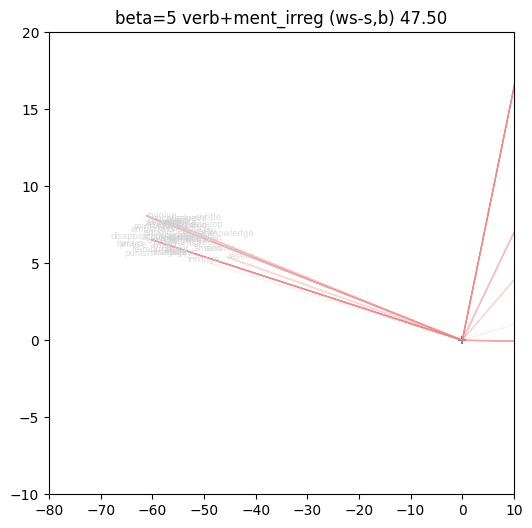

5,adj+ness_reg,37,42
ws_minus_s_hs.shape=(4096,)
bias.shape=(4096,)
cosine similarities pre_orthog=0.048 post_orthog=-0.000
proj_matrix.shape=(2, 4096)
['reasonable', 'unique', 'interesting', 'happy', 'devoted', 'careful', 'pure', 'serious', 'extensive', 'competitive', 'odd', 'strange', 'prepared', 'connected', 'related', 'broken', 'directed', 'cheap', 'aware', 'conscious', 'mad', 'amazing', 'innovative', 'hot', 'sad', 'vast', 'huge', 'fixed', 'foreign', 'rare', 'distinct', 'hidden', 'creative', 'dangerous', 'obvious', 'situated', 'useful', 'nice', 'helpful', 'sacred', 'massive', 'righteous', 'effective', 'impressive', 'distinctive', 'random', 'attractive', 'weak', 'marked', 'same']


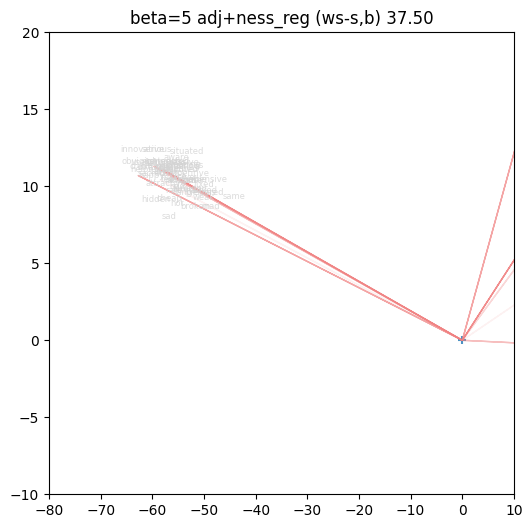

5,over+adj_reg,47,1
ws_minus_s_hs.shape=(4096,)
bias.shape=(4096,)
cosine similarities pre_orthog=0.012 post_orthog=-0.000
proj_matrix.shape=(2, 4096)
['optimistic', 'compensated', 'stated', 'sized', 'done', 'sold', 'played', 'ambitious', 'laid', 'charged', 'cooked', 'grown', 'paid', 'heated', 'arching', 'protected', 'taken', 'excited', 'used', 'booked', 'populated', 'stimulated', 'filled', 'strained', 'exposed', 'qualified', 'stretched', 'powered', 'thrown', 'stocked', 'protective', 'represented', 'zealous', 'subscribed', 'crowded', 'spent', 'dressed', 'developed', 'simplified', 'enthusiastic', 'inflated', 'stressed', 'heard', 'turned', 'painted', 'written', 'loaded', 'shadowed', 'confident', 'saturated']


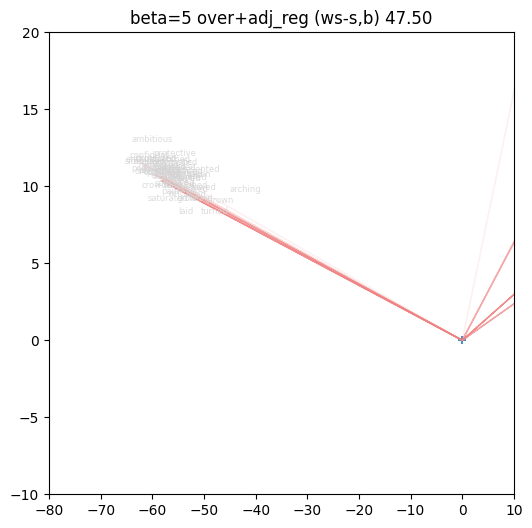

5,verb+er_irreg,32,33
ws_minus_s_hs.shape=(4096,)
bias.shape=(4096,)
cosine similarities pre_orthog=-0.128 post_orthog=-0.000
proj_matrix.shape=(2, 4096)
['receive', 'slay', 'skydive', 'suffer', 'deliver', 'offend', 'teach', 'recommend', 'subscribe', 'tell', 'publish', 'bake', 'observe', 'begin', 'determine', 'preach', 'defend', 'explore', 'intrude', 'destroy', 'promote', 'organize', 'learn', 'perform', 'send', 'write', 'consume', 'believe', 'borrow', 'molest', 'speak', 'entertain', 'advertise', 'mourn', 'choreograph', 'contend', 'lose', 'achieve', 'compose', 'interpret', 'manage', 'eat', 'listen', 'provide', 'organise', 'announce', 'examine', 'develop', 'follow', 'discover']


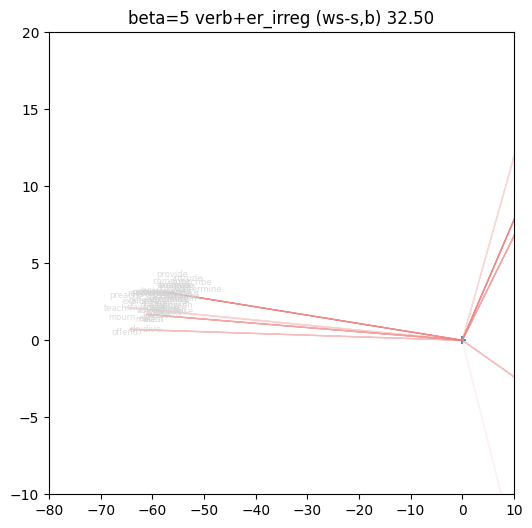

5,adj+ly_reg,40,38
ws_minus_s_hs.shape=(4096,)
bias.shape=(4096,)
cosine similarities pre_orthog=-0.218 post_orthog=0.000
proj_matrix.shape=(2, 4096)
['internal', 'extensive', 'critical', 'significant', 'mental', 'different', 'environmental', 'creative', 'international', 'historical', 'apparent', 'traditional', 'immediate', 'important', 'similar', 'financial', 'serious', 'visual', 'increasing', 'effective', 'typical', 'popular', 'political', 'strong', 'rare', 'clinical', 'decided', 'successful', 'beautiful', 'obvious', 'sexual', 'nice', 'unique', 'practical', 'cultural', 'actual', 'virtual', 'additional', 'digital', 'interesting', 'federal', 'physical', 'previous', 'subsequent', 'huge', 'according', 'legal', 'famous', 'regional', 'global']


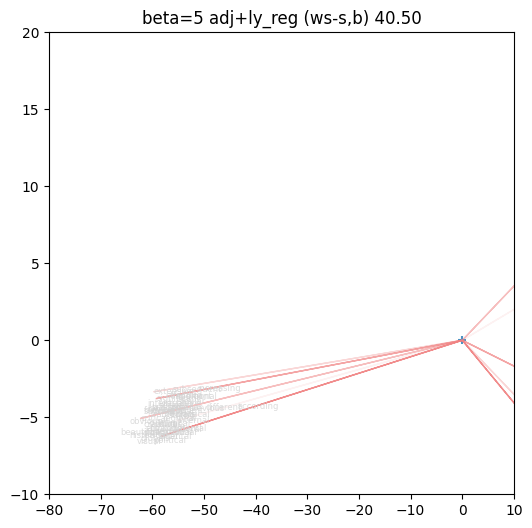

5,name - occupation,32,12
ws_minus_s_hs.shape=(4096,)
bias.shape=(4096,)
cosine similarities pre_orthog=-0.072 post_orthog=0.000
proj_matrix.shape=(2, 4096)
['pacino', 'strauss', 'hegel', 'haydn', 'dickens', 'hitler', 'euler', 'marx', 'mozart', 'pascal', 'confucius', 'rembrandt', 'wagner', 'stalin', 'michelangelo', 'wittgenstein', 'beethoven', 'locke', 'tolstoi', 'depp', 'truman', 'hume', 'dante', 'einstein', 'jolie', 'napoleon', 'spinoza', 'caesar', 'picasso', 'balzac', 'hawking', 'kepler', 'goethe', 'descartes', 'darwin', 'raphael', 'aristotle', 'kant', 'lincoln', 'columbus', 'edison', 'plato', 'shakespeare', 'moses', 'rousseau', 'schwarzenegger', 'newton', 'maxwell', 'mencius']


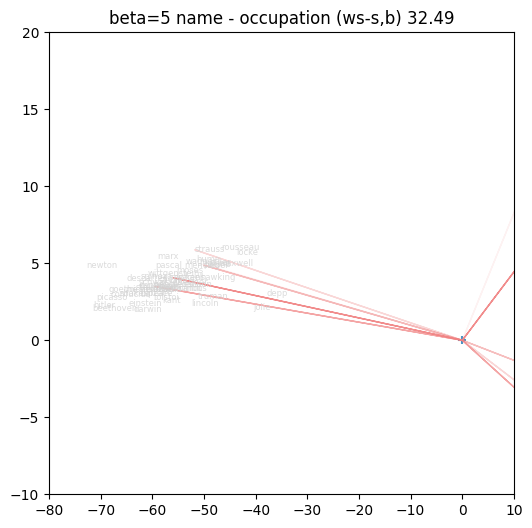

5,synonyms - intensity,8,2
ws_minus_s_hs.shape=(4096,)
bias.shape=(4096,)
cosine similarities pre_orthog=-0.385 post_orthog=0.000
proj_matrix.shape=(2, 4096)
['like', 'sea', 'boring', 'creative', 'doze', 'rain', 'monkey', 'guilty', 'tired', 'confused', 'pony', 'love', 'sad', 'drizzle', 'angry', 'ask', 'dinner', 'giggle', 'pain', 'chuckle', 'jog', 'strong', 'poorly', 'dislike', 'unfortunate', 'hungry', 'afraid', 'interesting', 'warm', 'snack', 'soon', 'necessary', 'bad', 'lake', 'tasty', 'unhappy', 'nap']


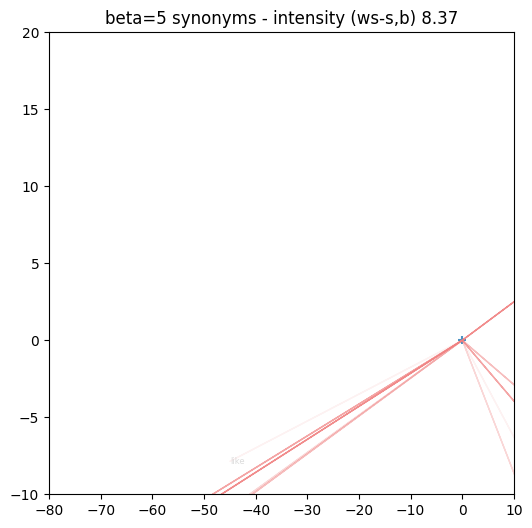

5,animal - sound,24,14
ws_minus_s_hs.shape=(4096,)
bias.shape=(4096,)
cosine similarities pre_orthog=-0.020 post_orthog=0.000
proj_matrix.shape=(2, 4096)
['frog', 'toad', 'turkey', 'duck', 'sheep', 'chimpanzee', 'wasp', 'fox', 'cattle', 'bee', 'goat', 'chicken', 'cicada', 'wolf', 'horse', 'seal', 'hound', 'rat', 'coyote', 'alpaca', 'mouse', 'moose', 'monkey', 'fly', 'bear', 'dog', 'gorilla', 'magpie', 'pig', 'lion', 'donkey', 'mallard', 'elk', 'cricket', 'snake', 'songbird', 'cat', 'pigeon', 'mule', 'hornet', 'tiger', 'elephant']


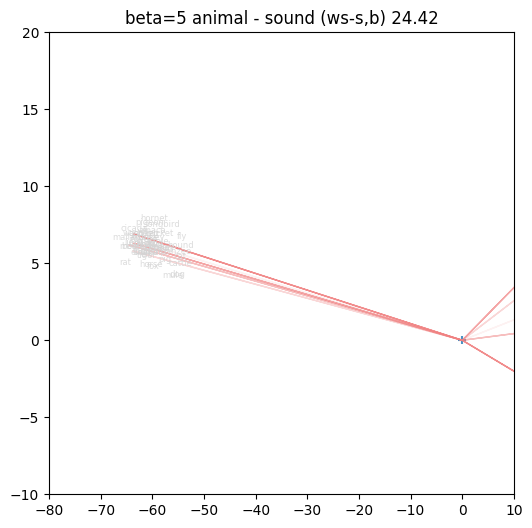

5,noun - plural_reg,50,50
ws_minus_s_hs.shape=(4096,)
bias.shape=(4096,)
cosine similarities pre_orthog=-0.223 post_orthog=0.000
proj_matrix.shape=(2, 4096)
['god', 'hour', 'period', 'application', 'song', 'street', 'office', 'solution', 'idea', 'member', 'population', 'player', 'year', 'council', 'month', 'friend', 'product', 'role', 'government', 'version', 'student', 'director', 'development', 'difference', 'college', 'river', 'town', 'road', 'system', 'user', 'website', 'day', 'fact', 'album', 'death', 'science', 'thing', 'law', 'village', 'car', 'customer', 'night', 'department', 'area', 'resource', 'example', 'problem', 'week', 'event', 'language']


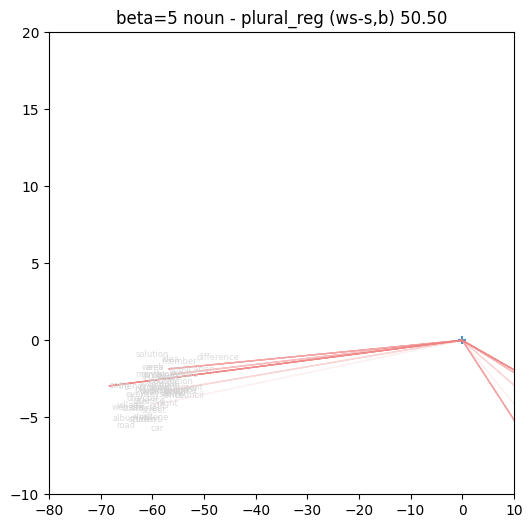

5,Ving - verb_inf,46,4
ws_minus_s_hs.shape=(4096,)
bias.shape=(4096,)
cosine similarities pre_orthog=-0.268 post_orthog=-0.000
proj_matrix.shape=(2, 4096)
['telling', 'avoiding', 'seeming', 'providing', 'establishing', 'expecting', 'continuing', 'identifying', 'promoting', 'referring', 'ensuring', 'requiring', 'learning', 'achieving', 'improving', 'containing', 'performing', 'creating', 'managing', 'losing', 'receiving', 'becoming', 'encouraging', 'spending', 'asking', 'considering', 'existing', 'appearing', 'representing', 'enjoying', 'believing', 'including', 'remembering', 'adding', 'reducing', 'allowing', 'teaching', 'following', 'operating', 'involving', 'attending', 'happening', 'maintaining', 'applying', 'developing', 'preventing', 'protecting', 'sitting', 'understanding', 'remaining']


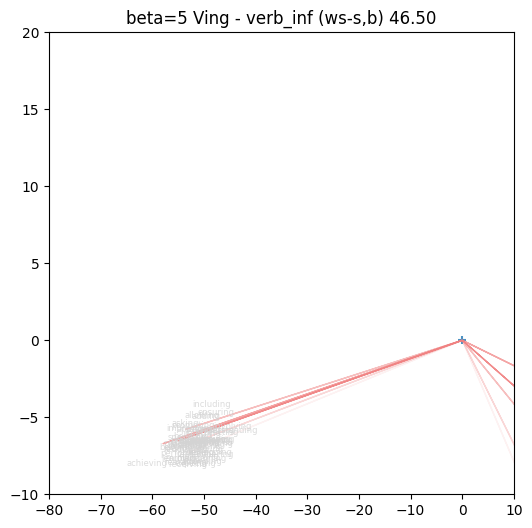

5,male - female,11,10
ws_minus_s_hs.shape=(4096,)
bias.shape=(4096,)
cosine similarities pre_orthog=-0.294 post_orthog=-0.000
proj_matrix.shape=(2, 4096)
['duke', 'sculptor', 'rooster', 'headmaster', 'dad', 'valet', 'grandson', 'father', 'brother', 'grandpa', 'lion', 'hound', 'boar', 'actor', 'waiter', 'batman', 'groom', 'boy', 'god', 'webmaster', 'emperor', 'chairman', 'poet', 'prince', 'businessman', 'son', 'hero', 'nephew', 'policeman', 'mister', 'husband', 'bull', 'murderer', 'king', 'heir', 'buck', 'manager', 'fisherman', 'stepfather', 'sir', 'superman', 'daddy', 'gentleman', 'grandfather']


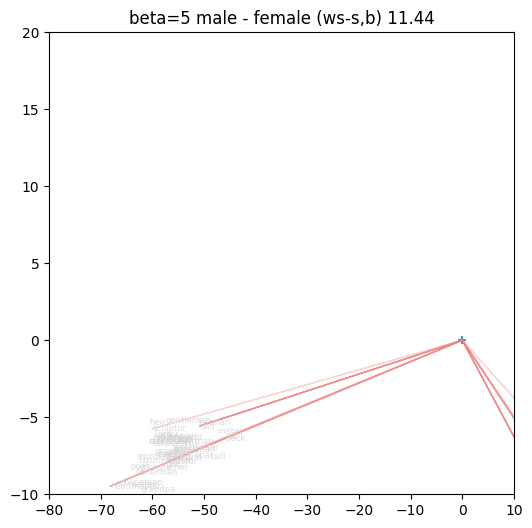

5,verb_3pSg - Ved,48,40
ws_minus_s_hs.shape=(4096,)
bias.shape=(4096,)
cosine similarities pre_orthog=-0.183 post_orthog=0.000
proj_matrix.shape=(2, 4096)
['remains', 'involves', 'develops', 'refers', 'follows', 'marries', 'asks', 'continues', 'contains', 'describes', 'establishes', 'suggests', 'publishes', 'replaces', 'applies', 'considers', 'becomes', 'includes', 'introduces', 'announces', 'provides', 'allows', 'decides', 'proposes', 'believes', 'loses', 'adds', 'sends', 'expects', 'appoints', 'consists', 'spends', 'happens', 'locates', 'operates', 'intends', 'manages', 'creates', 'agrees', 'tells', 'appears', 'performs', 'seems', 'hears', 'receives', 'relates', 'occurs', 'fails', 'requires', 'represents']


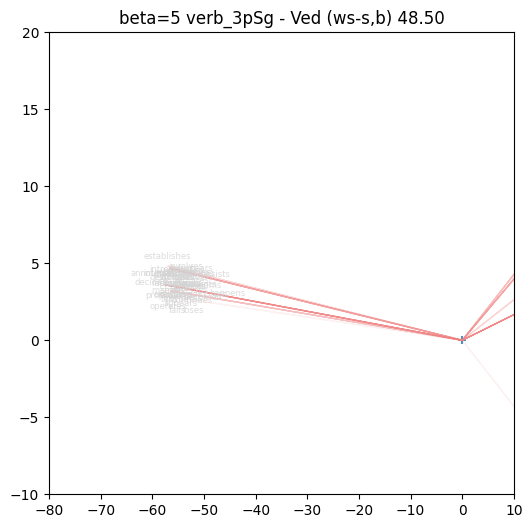

5,meronyms - member,21,11
ws_minus_s_hs.shape=(4096,)
bias.shape=(4096,)
cosine similarities pre_orthog=-0.116 post_orthog=0.000
proj_matrix.shape=(2, 4096)
['cow', 'policeman', 'acrobat', 'juror', 'person', 'bird', 'college', 'soldier', 'county', 'secretary', 'cattle', 'musician', 'parishioner', 'state', 'tree', 'senator', 'christian', 'student', 'galaxy', 'kitten', 'antelope', 'employee', 'star', 'player', 'bee', 'photo', 'member', 'wolf', 'book', 'citizen', 'flower', 'fish', 'division', 'elephant', 'lion', 'singer', 'calf', 'word', 'page', 'nomad', 'sheep', 'spouse']


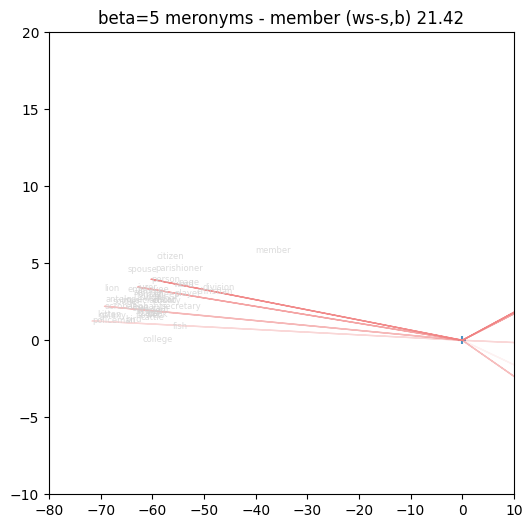

5,things - color,20,4
ws_minus_s_hs.shape=(4096,)
bias.shape=(4096,)
cosine similarities pre_orthog=0.083 post_orthog=0.000
proj_matrix.shape=(2, 4096)
['broccoli', 'blueberry', 'sugar', 'cabbage', 'blood', 'celery', 'fridge', 'chocolate', 'bruise', 'blackboard', 'raven', 'carrot', 'paper', 'milk', 'tea', 'toothpaste', 'snow', 'salt', 'leaves', 'crow', 'sun', 'tomato', 'coffee', 'soil', 'spinach', 'sapphire', 'cauliflower', 'sea', 'grass', 'cranberry', 'frog', 'grapes', 'cream', 'ant', 'rose', 'pepper', 'cucumber', 'apple', 'ruby', 'swan', 'cloud', 'sky', 'coal', 'parsley', 'peony', 'cherry', 'radish', 'emerald']


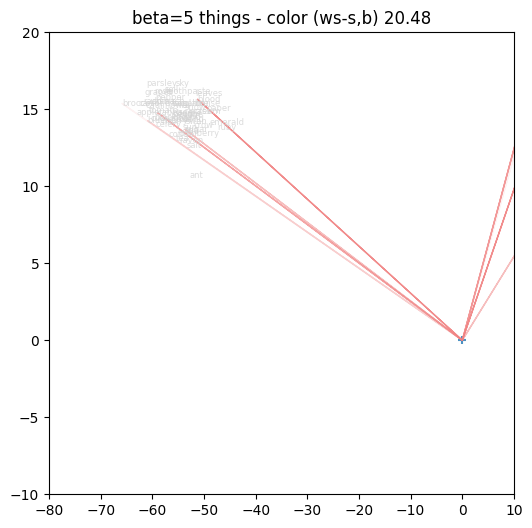

5,hyponyms - misc,12,10
ws_minus_s_hs.shape=(4096,)
bias.shape=(4096,)
cosine similarities pre_orthog=-0.219 post_orthog=0.000
proj_matrix.shape=(2, 4096)
['shoes', 'brush', 'burger', 'camera', 'painting', 'song', 'church', 'jewelry', 'cutlery', 'weekday', 'bed', 'cushion', 'car', 'book', 'emotion', 'cloud', 'citrus', 'tool', 'container', 'trousers', 'cookware', 'poem', 'jewel', 'collar', 'dress', 'drum', 'cup', 'weapon', 'boat', 'color', 'sofa', 'computer', 'sweater', 'shirt', 'mixer', 'bag', 'season', 'dessert', 'seat', 'spice', 'flask', 'guitar', 'gun', 'railway', 'toy', 'shelf', 'candy']


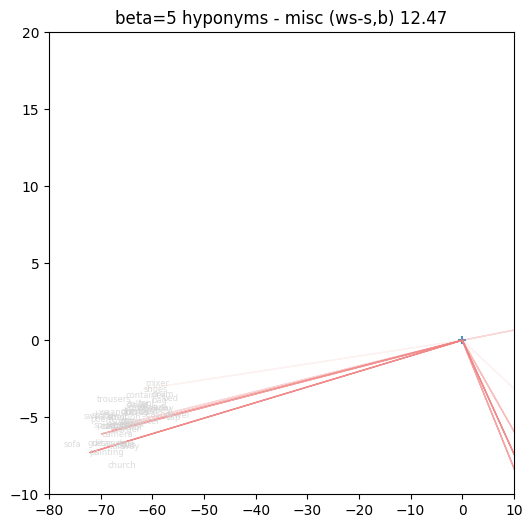

5,adj - superlative,35,36
ws_minus_s_hs.shape=(4096,)
bias.shape=(4096,)
cosine similarities pre_orthog=0.014 post_orthog=-0.000
proj_matrix.shape=(2, 4096)
['proud', 'able', 'vague', 'dense', 'pure', 'tasty', 'risky', 'clever', 'rare', 'wealthy', 'tiny', 'nice', 'dumb', 'costly', 'strong', 'handy', 'strange', 'hot', 'happy', 'sexy', 'fierce', 'sunny', 'harsh', 'healthy', 'noisy', 'lucky', 'polite', 'scary', 'tricky', 'cute', 'cheap', 'shiny', 'merry', 'hungry', 'sad', 'strict', 'lengthy', 'cruel', 'hardy', 'huge', 'rude', 'lazy', 'subtle', 'weird', 'weak', 'mild', 'neat', 'angry']


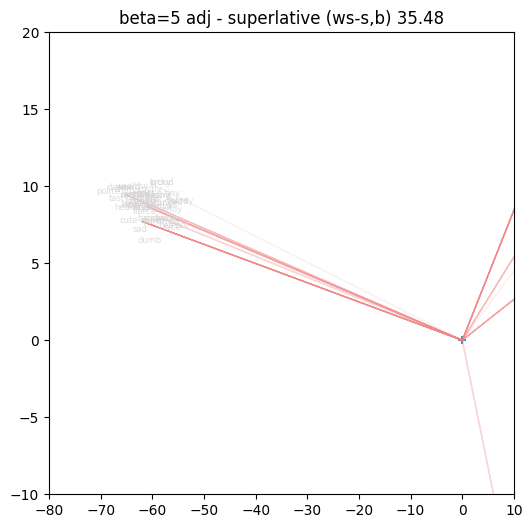

FileNotFoundError: [Errno 2] No such file or directory: '8_27_approx/.ipynb_checkpoints'

In [16]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from baukit.baukit import parameter_names, get_parameter
import torch.nn as nn
from collections import defaultdict
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import ConvexHull
from adjustText import adjust_text
import copy

# relations = [
#              # 'noun - plural_irreg',
#              # 'Ving - verb_inf','verb_Ving - Ved','verb_inf - Ved',\
#              #       'verb_inf - 3pSg','verb_Ving - 3pSg','noun - plural_reg','verb_3pSg - Ved',\
#                    #'adj - comparative*',
#              'adj - superlative','verb+er_irreg','over+adj_reg',
#                    'adj+ly_reg','verb+tion_irreg','verb+able_reg','un+adj_reg',\
#                    're+verb_reg','adj+ness_reg','noun+less_reg','verb+ment_irreg'
#             ]

relations = [
 'name - nationality',
 'animal - youth',
 'verb_Ving - 3pSg',
 'noun+less_reg',
 'verb+able_reg',
'UK_city - county',
 'antonyms - binary',
 'verb_inf - 3pSg',
 're+verb_reg',
 'verb_inf - Ved',
 'country - language',
 'meronyms - part',
 'verb_Ving - Ved',
'animal - shelter',
 'hypernyms - misc',
 'meronyms - substance',
 'noun - plural_irreg',
 'un+adj_reg',
 'verb+ment_irreg',
 'adj+ness_reg',
 'over+adj_reg',
 'verb+er_irreg',
 'adj+ly_reg',
 'name - occupation',
 'synonyms - intensity',
 'animal - sound',
 'noun - plural_reg',
 'Ving - verb_inf',
 'male - female',
 'verb_3pSg - Ved',
 'meronyms - member',
 'things - color',
 'hyponyms - misc',
 'adj - superlative',
 '.ipynb_checkpoints',
 'verb+tion_irreg',
 'synonyms - exact',
'hypernyms - animals',
 'country - capital'
]

def find_exact_match(filename, search_string):
    with open(filename, 'r') as file:
        for line in file:
            if search_string.lower() in line.strip().lower():
                return line.strip()
    print(f"Could not find {search_string}")
    return None

for beta in [5]:
    for relation in relations:
        wdir = f"{APPROX_FOLDER}/{relation}"
        samples = os.listdir(wdir)
        ignored_names = ['.ipynb_checkpoints']
        samples = [x for x in os.listdir(wdir) if x not in ignored_names]
        j_samples = random.sample(samples,8)
        reg_weight = build.mean_weight_or_bias(wdir,
                                               WEIGHT_NAME, j_samples).half().to(device)
        reg_bias = build.mean_weight_or_bias(wdir,
                                             BIAS_NAME, j_samples).half().to(device)
        json_path = find_exact_match("json_paths.txt", relation)
        file = open(json_path, 'r')
        data = json.load(file)
        file.close()
        
        relation = Relation.from_dict(data)
        prompt_template = relation.prompt_templates[0]
        
        rel_vecs = []
        for j_sample in j_samples:
            sample = [x for x in relation.samples if x.subject == j_sample][0]
            pair = (sample.subject, sample.object[0])
            subj_hs = ttnp(build.get_hidden_state(mt, pair[0], pair[0], 5))
            obj_hs = ttnp(build.get_hidden_state(mt, pair[1], pair[1], 27))
            rel_vec = obj_hs - subj_hs
            rel_vecs.append(rel_vec)
            
        #the mean vector from subj_hs to obj_hs.
        rel_vec = np.mean(rel_vecs, axis=0)

        #ASSEMBLE PROMPTS AND OBJECT ANSWERS
        clozed_prompts = []
        clozed_answers = []
        random.shuffle(relation.samples)
        for x in relation.samples:
            samples = [x] + random.sample(relation.samples, DEFAULT_N_ICL - 1)
            #print(f'{samples} samples)')
            cloze_prompt = functional.make_prompt(
                template = prompt_template, 
                target = x,
                examples = samples
                )
            clozed_prompts.append(cloze_prompt)
            clozed_answers.append(x.object)
        
        outputs_lm = functional.predict_next_token(mt=mt, prompt=clozed_prompts)
        preds_lm =  [[x.token for x in xs] for xs in outputs_lm]
        recall_lm = metrics.recall(preds_lm, clozed_answers)
        
        reg_correct = 0
        no_bias_correct = 0
        edited_correct = 0
        lm_correct = 0
    
        hs = defaultdict(list)
        hs["beta_hss_s"] = [[] for _ in range(0,10)]
        bias_dists = {}
        for i, sample, objs, prompt, preds in \
        zip(range(0,50), relation.samples, clozed_answers, clozed_prompts, preds_lm):
            
            if (metrics.any_is_nontrivial_prefix(predictions=preds, targets=objs)):
                #uses the regular LRE
                reg_hs = build.get_hidden_state(mt, prompt, sample.subject, start)
                reg_hs_end = build.get_hidden_state(mt, prompt, sample.subject, end)
                reg_object_hs = reg_hs.mm(reg_weight.t()) * beta + reg_bias
                
                no_bias_hs = reg_hs.mm(reg_weight.t())
                scaled_no_bias_hs = reg_hs.mm(reg_weight.t()) * beta

                reg_preds = build.get_object(mt, reg_object_hs)[0]
                no_bias_preds = build.get_object(mt, no_bias_hs)[0]
    
                norm_bias = torch.nn.functional.normalize(reg_bias[0], dim=0) #weight is (4096, 4096)
                #scaled_no_bias_hs = reg_hs.mm(reg_weight.t()) + 250 * norm_bias
                #edited_object_hs = reg_hs.mm(reg_weight.t()) + reg_bias / beta
                #edited_preds = build.get_object(mt, scaled_no_bias_hs)[0]
    
                if(metrics.any_is_nontrivial_prefix(predictions=[reg_preds[0]], targets=objs)):
                    reg_correct += 1
        
                if(metrics.any_is_nontrivial_prefix(predictions=[no_bias_preds[0]], targets=objs)):
                    no_bias_correct += 1
                    
                # if(metrics.any_is_nontrivial_prefix(predictions=[edited_preds[0]], targets=objs)):
                #     edited_correct += 1
                    
                if(i < VIEW_SAMPLES):
                    #print(f'{sample.subject} Ws+b {reg_preds[0:5]} Ws {no_bias_preds[0:5]}')
                    obj = copy.copy(sample.object[0])
                    #get the final state for the last token
                    # final_object_id = mt.tokenizer(sample.object[0]).input_ids[-1]
                    # final_object_token = mt.tokenizer.convert_ids_to_tokens(final_object_id)
                    # mod_prompt = prompt + f" {sample.object[0]}"
                    # sample.object[0] = f"{final_object_token}"
                    # fullobj_hs = build.get_final_state(mt, sample, mod_prompt)
                    
                    #get the final state for the INITIAL OBJECT TOKEN
                    init_object_id = mt.tokenizer(obj).input_ids[0]
                    init_object_token = mt.tokenizer.convert_ids_to_tokens(init_object_id)
                    mod_prompt = prompt + f" {obj}"
                    sample.object[0] = init_object_token
                    obj_hs = build.get_final_state(mt, sample, mod_prompt)
                    #print(f'{build.get_object(mt, obj_hs)[0][0:5]=}')
                    obj_dot_bias = np.dot(ttnp(obj_hs[0]), ttnp(reg_bias[0]))
                    #print(f'the dot of obj on bias is {obj_dot_bias}')
                    bias_dists[sample.subject] = obj_dot_bias
                    
                    ws_minus_s_hs = no_bias_hs - reg_hs
                    obj_minus_Ws_b_hs = obj_hs - reg_object_hs
                    obj_minus_Ws_hs = obj_hs - no_bias_hs
                        
                    #print(f'{betaLRE_over_LRE=}')
                    bbias_minus_bias_hs = (reg_bias / beta) - reg_bias
    
                    hs["objs_to_viz"].append(sample.subject)
                    #print(f'{reg_weight.shape=}')
                    hs["reg_weight_hss"].append(reg_weight)
                    hs["subj_hss"].append(reg_hs)
                    hs["reg_hss"].append(reg_object_hs)
                    hs["no_bias_hss"].append(no_bias_hs)
                    hs["scaled_no_bias_hss"].append(scaled_no_bias_hs)
                    hs["unscaled_hss"].append(no_bias_hs + reg_bias)
                    #hs["fullobj_hss"].append(edited_object_hs)
                    hs["obj_hss"].append(obj_hs)
                    hs["ws_minus_s_hss"].append(ws_minus_s_hs)
                    hs["obj_minus_Ws_b_hss"].append(obj_minus_Ws_b_hs)
                    hs["obj_minus_Ws_hss"].append(obj_minus_Ws_hs)
    
                    #8-18
                    for viz_beta in range(0,10):
                        beta_hss_s = hs["beta_hss_s"]
                        beta_object_hs = reg_hs.mm(reg_weight.t()) * (0+viz_beta*2) + reg_bias
                        beta_hss_s[viz_beta].append(beta_object_hs)
                lm_correct += 1
            
        #print(f'beta, name, Ws+b, Ws')
        print(f'{beta},{relation.name},{reg_correct},{no_bias_correct}')         

        rel_vec = rel_vec[0].reshape(1,-1)
        #print(f'{relation.name},{cosine_similarity(rel_vec, bias)}')
                                        
        # use the complete beta_hss_s
        # for i in range(0,10):
        #     avg_variance = get_variance(beta_hss_s[i], bias)
        #     print(f'beta={i+1} range wrt Ws: {avg_variance}')
        # reg_tensors = ttnp(hs["reg_hss"])
        # obj_tensors = ttnp(hs["obj_hss"])
        # avg_var_reg = get_variance(reg_tensors, bias)
        # avg_var_obj = get_variance(obj_tensors, bias)
        # print(f'beta,{beta},subj range,{avg_var_reg},obj range,{avg_var_obj}')
    
        #print(f'before ttnp: {hs['reg_weight_hss']}')
        hs = {k: ttnp(v) for k, v in hs.items()}
        #print(f'after ttnp: {hs['reg_weight_hss']}')
        bias = ttnp(reg_bias[0]).astype(np.float32)
        ws_minus_s_hs = np.mean(hs["ws_minus_s_hss"], axis=0)
        no_bias_hs = np.mean(hs["no_bias_hss"], axis=0)
        obj_minus_Ws_b_hs = np.mean(hs["obj_minus_Ws_b_hss"], axis=0)
        obj_minus_Ws_hs = np.mean(hs["obj_minus_Ws_hss"], axis=0)
        
        #this is not reg_weight (wrong shape 4096,4096), AFAICT basically a random vector
        reg_weight_hs = np.mean(hs["reg_weight_hss"], axis=0)
        
        
        reg_hs = np.mean(hs['reg_hss'], axis=0)
        unscaled_hs = np.mean(hs['unscaled_hss'], axis=0)

        rand_hs = np.random.rand(4096)

        # eig_vals, eig_vecs = np.linalg.eig(ttnp(reg_weight))
        # eig_vec1 = np.real(eig_vecs[:,0])
        
        #ws_minus_s_hs does share a lot with bias. This is Ok?
        print(f'{ws_minus_s_hs.shape=}')
        print(f'{bias.shape=}')
        # ##########################
        proj_matrix = viz.make_basis(ws_minus_s_hs, bias) #2nd orthogonalized to 1st.
        # ##########################
        print(f'{proj_matrix.shape=}')
        # proj_beta_hss_s = [np.dot(beta_hss, proj_matrix.T) for beta_hss in hs["beta_hss_s"]]

        # PLACEHOLDER FOR FULLOBJ_HSS
        #hs["fullobj_hss"] = np.random.rand(1,4096)
        # #hs["scaled_no_bias_hss"] = np.random.rand(1,4096)
        
        matrices = [rel_vec,hs["subj_hss"], hs["reg_hss"], hs["no_bias_hss"], hs["scaled_no_bias_hss"],
                    hs["obj_hss"], proj_matrix] #hs["fullobj_hss"]]
        
        proj_rel_hs,proj_subj_hss,proj_reg_hss,proj_no_bias_hss, proj_scaled_no_bias_hss, \
        proj_obj_hss,proj_w_matrix = viz.proj_matrices(matrices, proj_matrix)

        # sorted_bias_dists = dict(sorted(bias_dists.items(), key=lambda item: item[1]))
        #print(f'{proj_subj_hss.shape=} {proj_obj_hss.shape=}')
        #print(f'{sorted_bias_dists=}')
        title = f'beta={beta} {relation.name} (ws-s,b) {reg_correct}.{lm_correct}'
        print(hs["objs_to_viz"])
        viz.viz(-80,10,-10,20, title, hs["objs_to_viz"],
               proj_subj_hss,
               proj_no_bias_hss,
               proj_scaled_no_bias_hss,
               proj_reg_hss, 
               proj_obj_hss,
               None,#proj_fullobj_hss,
               None,#proj_beta_hss_s,
               #polygon=True,
               #ws=True,
               arrow=True,
               Bws=True,
               reg=True,
               obj=True,
               #fullobj=True,
               )

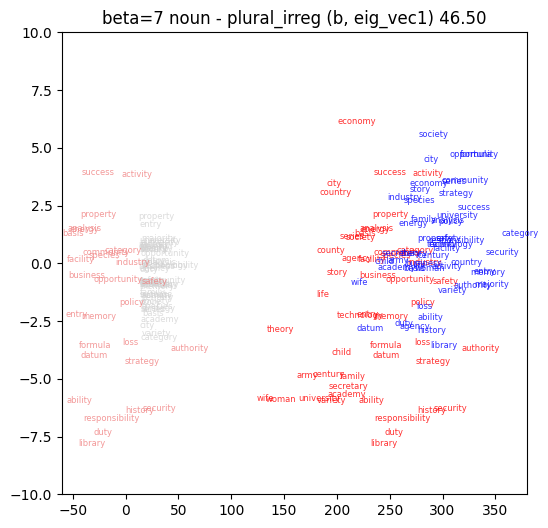

In [45]:
reload(build)
reload(functional)
reload(viz)
build.determine_device(mt)
build.determine_params(mt)

viz.viz(-60,380,-10,10, title, hs["objs_to_viz"],
               proj_subj_hss,
               proj_no_bias_hss,
               proj_scaled_no_bias_hss,
               proj_reg_hss, 
               proj_obj_hss,
               proj_fullobj_hss,
               proj_beta_hss_s,
               #polygon=True,
               #ws=True,
               #arrow=True,
               Bws=True,
               reg=True,
               obj=True,
               #fullobj=True,
               )

In [9]:
#compare sim of reg_hss against obj_hss

from sklearn.metrics.pairwise import cosine_similarity
print(no_bias_hss[0]) 

print("no bias similarities")
#get_object returns the NEXT token prediction for an embedding.
for subj, no_bias, obj, reg in zip(subj_hss, no_bias_hss, obj_hss, reg_hss):
    #print(build.get_object(mt, torch.Tensor(subj).to(device).half())[0]) #this one is not interpretable (h=5)
    print(build.get_object(mt, torch.Tensor(no_bias).to(device).half())[0])
    print(build.get_object(mt, torch.Tensor(reg).to(device).half())[0])
    print(build.get_object(mt, torch.Tensor(obj).to(device).half())[0])
    no_bias_sim = cosine_similarity(no_bias.reshape(1,-1), obj.reshape(1,-1))
    reg_sim = cosine_similarity(reg.reshape(1,-1), obj.reshape(1,-1))
    print(f'Ws: {no_bias_sim} Ws + b: {reg_sim}')

NameError: name 'no_bias_hss' is not defined

In [22]:
import sklearn
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import numpy as np

pca = PCA(n_components=3)
#tsne = TSNE(n_components=3, perplexity=5.0)

def transform_hs(hs):
    transformed_hs = pca.fit_transform(hs)
    #transformed_hs = tsne.fit_transform(transformed_hs)
    return transformed_hs
    
print(f'{subj_hss.shape=} {reg_hss.shape=} {no_bias_hss.shape=} {obj_hss.shape=}')
X = np.vstack([
              subj_hss,     #(50, 4096)
              reg_hss,      #(50, 4096)
              no_bias_hss,  #(50, 4096)
              obj_hss       #(50, 4096)
              # subj_hss_end, #(50, 4096)
                ])

X_3D =  transform_hs(X)
B1, B2, B3, B4, B5 = 20,40,60,80,100

subj_hss = X_3D[0:B1,:] #the subjects at h=5
reg_hss = X_3D[B1:B2,:] #the LRE objects at the end.
no_bias_hss = X_3D[B2:B3,:] #the Jac objects at the end.
obj_hss = X_3D[B3:B4,:] #the actual objects at the end

AttributeError: 'list' object has no attribute 'shape'

(20,) (20,) (20,)


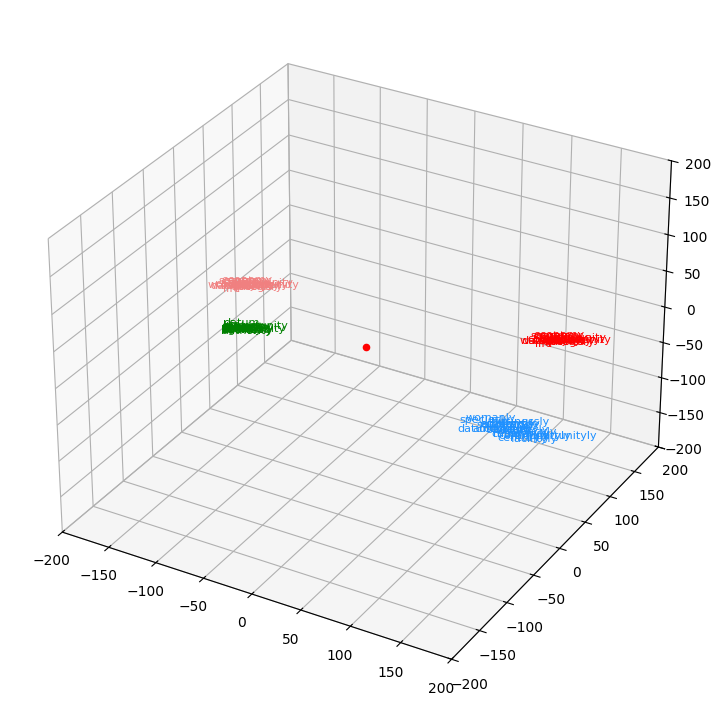

In [26]:
import matplotlib.pyplot as plt
#from mpl_tooklits.mplot3d import Axes3D

SCALE = 0.4

#there is an intelligible difference between the Ws and Ws + b arrows.
#Why isn't that difference the bias vector? Dim-reduce artifact?

#x0, y0, z0 = subj_hss.T

print(f'{x1.shape} {x2.shape} {x3.shape}')
fig = plt.figure(figsize=(15,9))
ax1 = fig.add_subplot(projection='3d')

# ax1.quiver(0,0,0, typically_hs[0], typically_hs[1], typically_hs[2], alpha=0.8,color="green",length=SCALE)
#ax1.quiver(0,0,0, reg_bias[0], reg_bias[1], reg_bias[2], alpha=0.8,color="black",length=SCALE)
    
ax1.scatter(0,0,0, color='r')
ax1.set_zorder(1)

# for text, x,y, z in zip(objs_to_viz, x0, y0, z0):
#     ax1.text(x,y,z, text, color='black', size=8, alpha=1)

#green text: the original embeddings, s
x0, y0, z0 = subj_hss.T
for text, x,y, z in zip(objs_to_viz, x0, y0, z0):
    ax1.text(x, y, z, text, color="green", size=8)
    
#light text: the Jacobian transformation, Ws.
x1, y1, z1 = no_bias_hss.T
for text, x,y, z in zip(objs_to_viz, x1, y1, z1):
    ax1.text(x, y, z, text, color="lightcoral", size=8)
    
#dark text: the LRE transformation, Ws + b
#Why is the bias creating variation?
x2, y2, z2 = reg_hss.T
for text, x,y, z in zip(objs_to_viz,x2, y2, z2):
    ax1.text(x, y, z, text, color="red", size=8)
    
#With only the three outputs, the picture seems clearer.
x3, y3, z3 = obj_hss.T
for text, x,y, z in zip(objs_to_viz, x3, y3, z3):
    ax1.text(x,y,z, f'{text}ly', color='dodgerblue', size=8, alpha=1)
    
for ax in [ax1]:
    ax.set_xlim(-200, 200)
    ax.set_ylim(-200,200)
    ax.set_zlim(-200,200)

plt.show()

In [83]:
objs_to_viz

['internally',
 'virtually',
 'seriously',
 'creatively',
 'environmentally',
 'practically',
 'successfully',
 'nicely',
 'historically',
 'physically',
 'decidedly',
 'financially',
 'popularly',
 'interestingly',
 'digitally',
 'sexually',
 'accordingly',
 'previously',
 'extensively',
 'actually',
 'beautifully',
 'mentally',
 'additionally',
 'famously',
 'immediately',
 'legally',
 'traditionally',
 'rarely',
 'differently',
 'visually',
 'subsequently',
 'effectively',
 'federally',
 'critically',
 'apparently',
 'internationally',
 'globally',
 'increasingly',
 'similarly',
 'hugely',
 'importantly',
 'regionally',
 'politically',
 'strongly',
 'typically',
 'clinically',
 'significantly',
 'culturally',
 'obviously',
 'uniquely']

In [71]:
import sys
print(sys.executable)

/home/exia/miniconda3/envs/my-lre/bin/python


In [78]:
mt.model.transformer

GPTJModel(
  (wte): Embedding(50400, 4096)
  (drop): Dropout(p=0.0, inplace=False)
  (h): ModuleList(
    (0-27): 28 x GPTJBlock(
      (ln_1): LayerNorm((4096,), eps=1e-05, elementwise_affine=True)
      (attn): GPTJAttention(
        (attn_dropout): Dropout(p=0.0, inplace=False)
        (resid_dropout): Dropout(p=0.0, inplace=False)
        (k_proj): Linear(in_features=4096, out_features=4096, bias=False)
        (v_proj): Linear(in_features=4096, out_features=4096, bias=False)
        (q_proj): Linear(in_features=4096, out_features=4096, bias=False)
        (out_proj): Linear(in_features=4096, out_features=4096, bias=False)
      )
      (mlp): GPTJMLP(
        (fc_in): Linear(in_features=4096, out_features=16384, bias=True)
        (fc_out): Linear(in_features=16384, out_features=4096, bias=True)
        (act): NewGELUActivation()
        (dropout): Dropout(p=0.0, inplace=False)
      )
    )
  )
  (ln_f): LayerNorm((4096,), eps=1e-05, elementwise_affine=True)
)

In [82]:
mt.model.config1

GPTJConfig {
  "_name_or_path": "EleutherAI/gpt-j-6B",
  "activation_function": "gelu_new",
  "architectures": [
    "GPTJForCausalLM"
  ],
  "attn_pdrop": 0.0,
  "bos_token_id": 50256,
  "embd_pdrop": 0.0,
  "eos_token_id": 50256,
  "gradient_checkpointing": false,
  "initializer_range": 0.02,
  "layer_norm_epsilon": 1e-05,
  "model_type": "gptj",
  "n_embd": 4096,
  "n_head": 16,
  "n_inner": null,
  "n_layer": 28,
  "n_positions": 2048,
  "resid_pdrop": 0.0,
  "rotary_dim": 64,
  "summary_activation": null,
  "summary_first_dropout": 0.1,
  "summary_proj_to_labels": true,
  "summary_type": "cls_index",
  "summary_use_proj": true,
  "task_specific_params": {
    "text-generation": {
      "do_sample": true,
      "max_length": 50,
      "temperature": 1.0
    }
  },
  "tie_word_embeddings": false,
  "tokenizer_class": "GPT2Tokenizer",
  "torch_dtype": "float16",
  "transformers_version": "4.41.2",
  "use_cache": true,
  "vocab_size": 50400
}

Sequential(
  (0): LayerNorm((4096,), eps=1e-05, elementwise_affine=True)
  (1): Linear(in_features=4096, out_features=50400, bias=True)
)

In [ ]:
### LRE BETA INSERTION POSITION
json_path = 'qapprox/antonyms-binary.json'

DEFAULT_N_ICL = 8 
N_TRIALS = 8

with open(json_path, 'r') as file:
    data = json.load(file)
    relation = Relation.from_dict(data)
    prompt = "The opposite of {} is"
    prompt_template = relation.prompt_templates[0]
    beta = 2.75
    for beta_layer in range(5,27):
        print(f'{beta_layer=}')
        for _ in range(0,N_TRIALS):
            clozed_prompts = []
            clozed_answers = []
            for x in relation.samples:
                samples = [x] + random.sample(relation.samples, DEFAULT_N_ICL - 1)
                cloze_prompt = functional.make_prompt(
                    template = prompt_template, 
                    target = x,
                    examples = samples
                    )
                clozed_prompts.append(cloze_prompt)
                clozed_answers.append(x.object)
            outputs_lm = functional.predict_next_token(mt=mt, prompt=clozed_prompts)
            preds_lm =  [[x.token for x in xs] for xs in outputs_lm]
            recall_lm = metrics.recall(preds_lm, clozed_answers)
            lre_correct = 0
            lm_correct = 0
            
            for _, sample, objs, prompt, preds in zip(range(50), relation.samples, clozed_answers, clozed_prompts, preds_lm):
                if (metrics.any_is_nontrivial_prefix(
                    predictions=preds, 
                    targets=objs)):
                    hs = build.get_hidden_state(mt, prompt, sample.subject, 1) #layer 5
                    object_hs = approx_lm(hs, beta, beta_layer)
                    lre_preds = get_object(mt, object_hs)[0]
                    if(metrics.any_is_nontrivial_prefix(predictions=lre_preds, targets=objs)):
                        lre_correct += 1
                    lm_correct += 1
                    
            print(f'{lre_correct} {lm_correct}')

In [54]:
#for most relations.
def is_nontrivial_prefix(prediction: str, target: str) -> bool:
    target = target.lower().strip()
    prediction = prediction.lower().strip()
    # if len(prediction) > 0 and target.startswith(prediction):
    #     print(f"{prediction} matches {target}")
    return len(prediction) > 1 and target.startswith(prediction)

def any_is_nontrivial_prefix(prediction, targets) -> bool:
    return any(is_nontrivial_prefix(prediction, target) for target in targets)

In [55]:
for (subj, obj) in pairs:
    for beta in range(10,50, 1):
        beta /= 10
        hs = get_hidden_state(mt, subj, 5) #layer 5
        object_hs = approx_lm(hs, beta) #beta
        pred = get_object(mt, object_hs)[0]
        if (any_is_nontrivial_prefix(pred[0], obj)):
            print(f"{subj} matches {pred[0]}: {beta}")
            break
    
# for (subj, obj) in pairs:
#     hs = get_hidden_state(mt, subj, 5)
#     object_hs = approx_lm(hs, 2.4)
#     print(f'{subj}: {get_object(mt, object_hs)[0]} {obj}')

NameError: name 'pairs' is not defined

In [ ]:
#get tokens in GPT-J
#get the hidden state of them at the last layer (after the 28th layer, or s->o @ 27)
import pickle
from tqdm import tqdm

def get_hidden_state(mt, subject, h_layer, h=None, k=5):
    prompt = f" {subject}"
    h_index, inputs = functional.find_subject_token_index(
        mt = mt, prompt=prompt, subject=subject)
    #print(f'h_index is {h_index}, inputs is {inputs}')
    [[hs], _] = functional.compute_hidden_states(
        mt = mt, layers = [h_layer], inputs = inputs)
    #h is hs @ h_layer @ h_index
    h = hs[:, h_index]
    h = h.to(device)
    return h
    
#Spaces are converted in a special character (the Ġ ) in the tokenizer prior to BPE splitting
#mostly to avoid digesting spaces since the standard BPE algorithm used spaces in its process 

#all animal encodings are at [-0.4153   2.023   -2.23    ... -0.785    0.06323 -0.1819 ]

text = "our classic pre-baked blueberry pie filled with delicious plump and juicy wild blueberries"
encoded_input = mt.tokenizer(text, return_tensors="pt")
token_ids = range(0,50400)
tokens = tokenizer.convert_ids_to_tokens(token_ids)
tokens = [token.replace("Ġ", " ") for token in tokens]

#this is too slow and not useful.
dict27 = {}
for i in tqdm(range(len(tokens))):
    token = tokens[i]
    dict27[token] = get_hidden_state(mt, token, 27)
    
with open('animal_youth_27.pkl', 'wb') as file:
    pickle.dump(dict27, file)

In [211]:
mt.lm_head

Sequential(
  (0): LayerNorm((4096,), eps=1e-05, elementwise_affine=True)
  (1): Linear(in_features=4096, out_features=50400, bias=True)
)

In [8]:
animals = ["dog", "duck", "fish", "horse", "mink", "seal", "shark", "trout"]

[' puppy', ' pup', ' p', ' dog', ' �']
[' duck', ' dra', ' g', ' �', ' "']
[' fry', ' prog', ' F', ' �', ' lar']
[' fo', ' col', ' horse', ' pony', ' �']
[' kit', ' m', ' "', ' �', ' p']
[' seal', ' "', ' �', ' pup', ' p']
[' shark', ' "', ' �', ' p', ' pup']
[' fry', ' trout', ' "', ' �', ' rainbow']
